In [2]:
cd games

/Users/eduardodaroza/intro_dsi/capstone/Capstone/games


Loaded chess data in /src/dataloading.py to assemble combined.pgn

# Chess Prediction and Recommendation


#### A Capstone Project by Eduardo Daroza - Galvanize Data Science Immersive

*using CRISP - DM (Cross Industry Standard Process for Data Mining)


1. Business Understanding
---

This initial phase focuses on understanding the project objectives and requirements from a business perspective, and then converting this knowledge into a data mining problem definition, and a preliminary plan designed to achieve the objectives. A decision model, especially one built using the Decision Model and Notation standard can be used.


In chess, prediction of your opponents opening choice prior to the game provides a competitive advantage especially if a player has time to prepare some counter strategies.  Statistically studies have shown that playing white provides a small but measurable advantage in practive since white has the first move and may general has more influence in the opening battle.  

This capstone project will use chess data freely available on the web to aid in opening prediction to aid in the pre-game preparation for a chess player.  The goal will be train an ensemble model to first predict likely opening White moves based a data set of two million games and then to recommend those openings moves which should provide a better likelihood probability of success based on your opponents prior history and that of the likelihood of success of the opening in the dataset.  I will be breaking up the problem into two parts. 

i: First predict the three most likely moves to be made by the opponent.

ii: Second based on the data which responses provide the likelihood of success and to estimate the probability of success for those responses.

The user interface will be presented online on Elastic Beanstalk web use flask and a NoSQL db such as mongodb or Dynamodb to store the games for retrieval.

If time allows, I will explore chess style based on openings to try to provide categories of players and provide an interface for the user to practice the opening recommendations using stockfish open source engine.


2. Data Understanding
---
The data understanding phase starts with an initial data collection and proceeds with activities in order to get familiar with the data, to identify data quality problems, to discover first insights into the data, or to detect interesting subsets to form hypotheses for hidden information.


The web has several chess datasets consisting of millions of historical games.  Chess games are stored in a PGN (portable game notation) file format which is ascii readable and provides the game as well as metadata including the players, ratings, date, and result. 

My first dataset was obtained from http://www.top-5000.nl/pgn.htm as the 2.2 millionbase consisting of over 2 million games.  After some initial data exploration I found some of my own games, however more than 40% of the meta data was incomplete include opening information.  Attempts to scrape the missing data where resource intensive and error prone so I was able to find an alternative data set which had much better data fidelity.

3. Data Preparation
---
The data preparation phase covers all activities to construct the final dataset (data that will be fed into the modeling tool(s)) from the initial raw data. Data preparation tasks are likely to be performed multiple times, and not in any prescribed order. Tasks include table, record, and attribute selection as well as transformation and cleaning of data for modeling tools.

I used pandas for much of my initial EDA with a shard of 40,000 games and built my Minimal Viable product.  Below I have included some of the observations I made during the data exploration phase and the subsequent data cleaning and feature engineering used prior to the modeling phase. There is a seperate dataloading.py in my github repo which has some code used to combine the seperate pgns and some webscraping functions.



In [4]:
import sys  

reload(sys)  
sys.setdefaultencoding('utf8')
from __future__ import unicode_literals

game={}
games = []

pgn_file="combined.pgn"

with open(pgn_file,'r') as datafile:
    for line in datafile:
        line = line.decode('latin-1').encode("utf-8")       
        if line.startswith('['):
            tag,value=line[1:-1].split(' ',1)
            game[str(tag).lower()]=value.replace("]","").strip('"').encode('ascii', 'ignore')
        elif line.startswith('1.'):
            #only read first line: could add more readlines until a space
            game['moves']=line.encode('ascii', 'ignore')
            games.append(game)
            game = {}

In [5]:
df = pd.DataFrame(games) 

Ran into some encoding/unicode issues preventing loading so added decode('latin-l') due to some special character in the file.  And '"\r' was being appended during the dataloading so addressed this in data cleaning.

In [7]:
df.head(1)

,black,blackelo,date,eco,event,eventdate,fen,moves,result,round,setup,site,white,whiteelo
0,"Kosteniuk, Alexandra""\r","2554""\r","2016.02.29""\r","A05""\r","IMSA Blitz w 2016""\r","2016.02.28""\r",NaN,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,"0-1""\r","15.5""\r",NaN,"Huai'an CHN""\r","Harika, Dronavalli""\r","2511""\r"


In [8]:
#garbage = test.pop('blackteam')
#garbage = test.pop('blacktitle')
#garbage = test.pop('whiteteam')
#garbage = test.pop('whitetitle')
garbage = df.pop('eventdate')
#garbage = df.pop('eventtype')
garbage = df.pop('site')
#garbage = test.pop('variation')
#garbage = df.pop('eco') # most precise drop for now in first dumb model
#garbage = test.pop('blackfideid')
#garbage = test.pop('whitefideid')
garbage = df.pop('event')
garbage = df.pop('fen')
garbage = df.pop('setup')
garbage = df.pop('round') # may have alot of variance, drop for now
#garbage = data_df.pop('opening') # second most precise drop for now in first dumb model

In [10]:
df.white = df.white.map(lambda x: x.rstrip('"\r'))
df.black = df.black.map(lambda x: x.rstrip('"\r'))
df.blackelo = df.blackelo.map(lambda x: x.rstrip('"\r'))
df.date = df.date.map(lambda x: x.rstrip('"\r'))
df.eco = df.eco.map(lambda x: x.rstrip('"\r'))
df.result = df.result.map(lambda x: x.rstrip('"\r'))
df.whiteelo = df.whiteelo.map(lambda x: x.rstrip('"\r'))

In [11]:
d = {
'0-1':-1.0,
'1-0':1.0,
'1/2-1/2':0.0
}
#update feature
df['result'] = df['result'].map(d)


In [12]:
df.date = map(lambda x: str(x).replace(".",""),df.date)
df.date = pd.to_datetime(df.date, format='%Y%m%d', errors='ignore')
df['white_first_move'] = df.moves.apply(lambda x: x.split(" ")).apply(lambda x: x[0])
df['black_first_move'] = df.moves.apply(lambda x: x.split(" ")).apply(lambda x: x[1])

In [13]:
import pandas as pd
import datetime as DT
import io
import numpy as np
import math
from matplotlib import pyplot as plt
now = pd.Timestamp(DT.datetime.now())
#df['age'] = (now - df['date']).astype('timedelta64[D]')

In [ ]:
#inpute some dates for rows with "??"

In [14]:
df.date = map(lambda x: str(x).replace("?","1"),df.date)
str(df.date).find("?") #validate no more missing
df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d', errors='coerce'))

df['age'] = (now - df['date']).astype('timedelta64[D]')
garbage = df.pop('date')


In [17]:
min(df.age)

261.0

In [15]:
#drop some incomplete data
df.white_first_move.unique()
df[df.white_first_move == '2.c3']


,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age
1114192,"Jurkovic, Hrvoje",2426,B22,1...c5 2.c3 Nf6 3.e5 Nd5 4.d4 cxd4 5.Nf3 Nc6 6...,-1.0,"Jeric, Simon",2328,2.c3,Nf6,3658.0


In [16]:
df = df.drop(df.index[1114192])

In [18]:

def win_estimate_df(df,adj=32):
    """input is two ratings ratingA (white), ratingB (black)
    and an optional adjustment factor (adj) which will be added
    to ratingA (white). Usually white has a small advantage which
    has been observed to be about +32 to +50"""
    df[0] = df[0]+adj
    diff = df[1]-df[0]
    ex = diff/400.
    return 1/(1+math.pow(10,ex))

df.whiteelo = df.whiteelo.astype(int)
df.blackelo = df.blackelo.astype(int)

df['estimate_white_win_by_rating'] = df[['whiteelo','blackelo']].apply(win_estimate_df,axis=1)

df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)


In [20]:
df.head()

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,diff
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,Nf6,2.g3,261.0,0.484175,43
1,"Ju, Wenjun",2558,A34,1.c4 c5 2.g3 Nf6 3.Bg2 d5 4.cxd5 Nxd5 5.Nc3 Nc...,-1.0,"Mkrtchian, Lilit",2434,c5,2.g3,261.0,0.370611,124
2,Wang Yue,2718,A18,1.c4 Nf6 2.Nc3 e6 3.e4 d5 4.e5 d4 5.exf6 dxc3 ...,-1.0,"Ivanchuk, Vassily",2710,Nf6,2.Nc3,261.0,0.534484,8
3,"Krush, Irina",2458,A25,1.c4 e5 2.Nc3 Nc6 3.g3 g6 4.Bg2 Bg7 5.e4 d6 6....,-1.0,"Mkrtchian, Lilit",2434,e5,2.Nc3,261.0,0.511511,24
4,"Paehtz, Elisabeth",2472,A26,1.Nf3 d6 2.g3 g6 3.Bg2 Bg7 4.O-O Nf6 5.d3 O-O ...,-1.0,"Huang, Qian",2450,d6,2.g3,261.0,0.514387,22


In [19]:
df['diff'] = df['blackelo']-df['whiteelo']

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,diff
0,"Aaberg, Anton",72,72,72,72,72,72,72,72,72,72,72
1,"Aabling-Thomsen, Jakob",175,175,175,175,175,175,175,175,175,175,175
2,"Aadeli, Arvin",2,2,2,2,2,2,2,2,2,2,2
3,"Aagaard, Gert",8,8,8,8,8,8,8,8,8,8,8
4,"Aagaard, Jacob",454,454,454,454,454,454,454,454,454,454,454


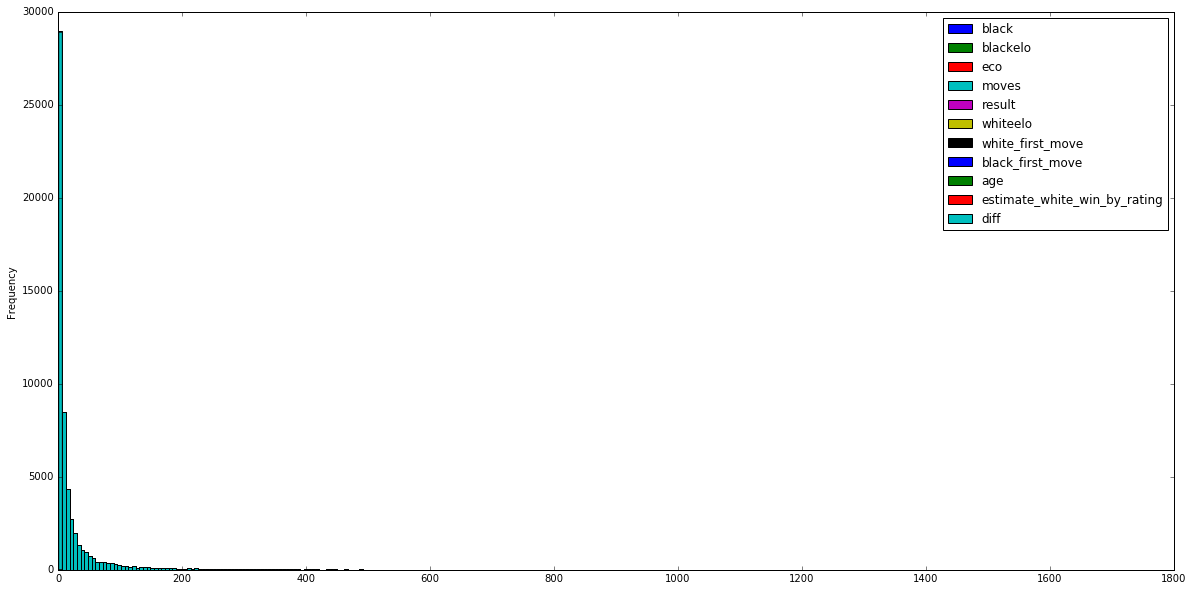

In [23]:
#some EDA:
%matplotlib inline

df.groupby('white').count().sort('black',ascending=False).plot(kind='hist',bins=300,figsize=(20,10))

#how many times in the database by color
df.groupby('white').count().reset_index().head()
df.groupby('black').count().reset_index().head()


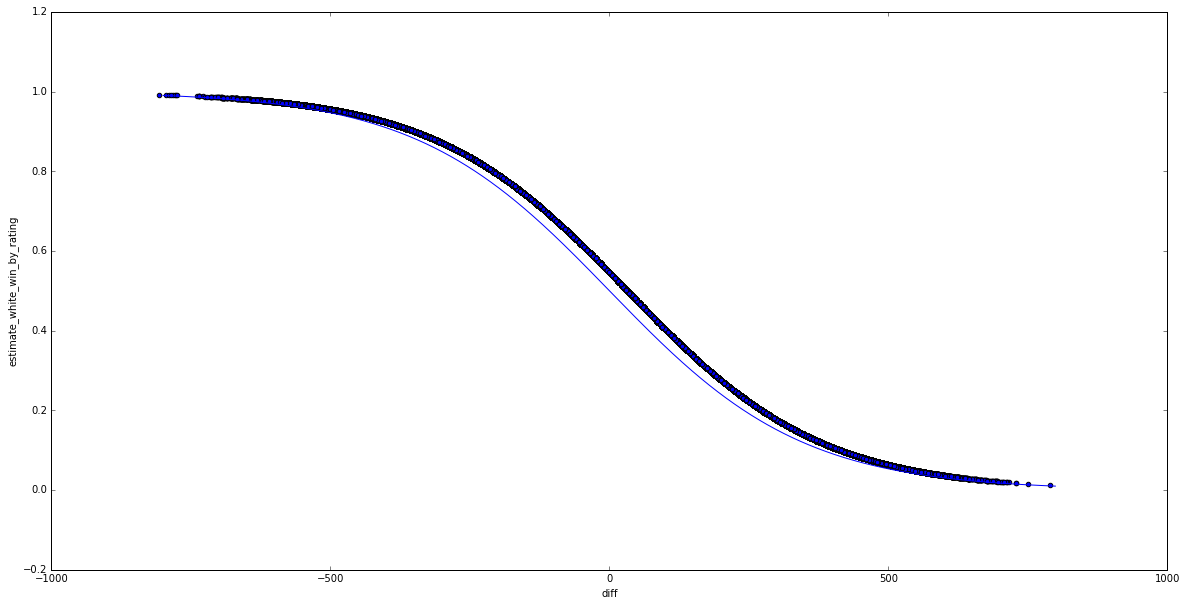

In [24]:
# elo formula vs scatter plot of the actual results by rating difference:
from math import pow 
df[['diff','estimate_white_win_by_rating']].plot(kind='scatter',x='diff',y='estimate_white_win_by_rating',figsize=(20,10))
t = xrange(-800,800,1)
s=[]
for item in t:
    output = 1.0/(1 + math.pow(10.0,item/400.0))
    s.append(output)
plt.plot(t, s)


165.32050455649426

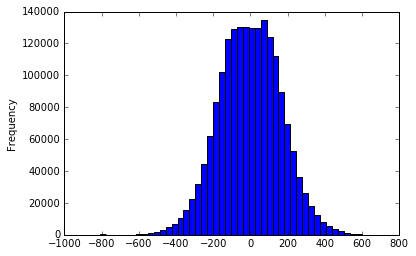

In [25]:

#avg rating difference between players is small
df['diff'].sum()/df['diff'].count()
#pairings end up being a normal distribution based on rating
df['diff'].plot(kind='hist',bins=50)
# 2 sigma is +/-330 points so one class above and below
df['diff'].std()


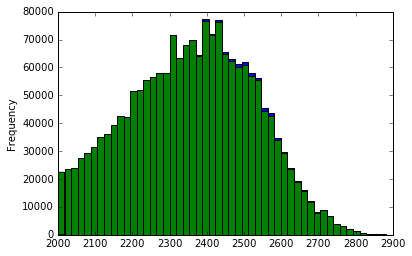

In [26]:

#ratings distribution
df.whiteelo.plot(kind='hist',bins=50)
df.blackelo.plot(kind='hist',bins=50)

#statistically different ratings?
#what are the confidence levels...can i say about similar ratings to normalize opening results?

#add number of games in the database by player...related to activity as well as time since last tournament.
#then use linear regression to predict avg rating drop between tournaments.
#count number of player by opening

garbage = df.pop('black_first_move')
garbage = df.pop('diff')


df["white"] = df["white"].astype('category')
df['black'] = df['black'].astype('category')

In [33]:
df.head(1)

,black,blackelo,eco,result,white,whiteelo,white_first_move,age,estimate_white_win_by_rating
0,"Kosteniuk, Alexandra",2554,A05,-1.0,"Harika, Dronavalli",2511,1.Nf3,261.0,0.484175


In [34]:
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [35]:
df.count()

black                           1861396
blackelo                        1861396
eco                             1861396
result                          1861396
white                           1861396
whiteelo                        1861396
white_first_move                1861396
age                             1861396
estimate_white_win_by_rating    1861396
dtype: int64

In [32]:
garbage = df.pop('moves')

In [ ]:
#additional feature engineering

In [46]:
df.groupby('white')['black'].count().head()

white
Aaberg, Anton              75
Aabling-Thomsen, Jakob    163
Aadeli, Arvin               2
Aagaard, Gert               4
Aagaard, Jacob            439
Name: black, dtype: int64

In [47]:
df.groupby('black')['white'].count().head()

black
Aaberg, Anton              72
Aabling-Thomsen, Jakob    175
Aadeli, Arvin               2
Aagaard, Gert               8
Aagaard, Jacob            454
Name: white, dtype: int64

In [44]:
df.head(1)

,black,blackelo,eco,result,white,whiteelo,white_first_move,age,estimate_white_win_by_rating,player_as_white,player_as_black
0,"Kosteniuk, Alexandra",2554,A05,-1.0,"Harika, Dronavalli",2511,1.Nf3,261.0,0.484175,NaN,NaN


#considered booleanizing titled/non-titled

One unanticipated challenge was creating categorical information on the player names which was a feature that had a strongest correlation to the target value of predicting opening moves.  After I transitions from shard to the total dataset of 1.8 million games, I found that the data set had over 57,000 unique player names.  Using pandas pd.get_dummies method exceed my system memory and caused my kernel to crash.  

So for the final product I will need to investigate alternative solutions such as dividing this categorical labeling into subsets and then merging them.  Alternatively, Matt suggested that I investigate using the hash trick which would hash my unique features and reduce the dimension.  One consequence of the latter option would bucket users into arbitrary groups which may have some unwanted variance to the dataset.  Yet another suggestion from Miles would be to feature engineer some groups of player styles or classes to reduce dimensionality. Lastly, I could simply reduce the number of players by only keeping those that meet a threshold of minimum number of games for example > 3 games.  This would greatly reduce the dataset and potentially allow me to use the get_dummies method on all the data. I will explore these options in greater details in week two.

4. Modeling
---
In this phase, various modeling techniques are selected and applied, and their parameters are calibrated to optimal values. Typically, there are several techniques for the same data mining problem type. Some techniques have specific requirements on the form of data. Therefore, stepping back to the data preparation phase is often needed.


The other part of modeling that I needed to consider was if the player had little or no data in the database.  The solution that I decided on after some discussion with peers and instructors was to create a seperate model that had the player names removed and use this if the user entered name was't found in the data set.  In addition I may be able to use both the player based and non-player based models in some weighted ensemble to get the desired result of using a more general model if there was only a few games in the dataset.

array([u'1.Nf3', u'1.c4', u'1.c4', ..., u'1.e4', u'1.e4', u'1.e4'], dtype=object)

In [5]:
#modeling
y = df['white_first_move'].values
y_eco = df['eco'].values
X = df[['blackelo','result','whiteelo','age','estimate_white_win_by_rating']].values

#trainsplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import tree

clf1 = LogisticRegression(random_state=123)
clf2 = RandomForestClassifier(random_state=123,n_estimators=10)
clf3 = GaussianNB()
clf4 = MultinomialNB()
clf5 = tree.DecisionTreeClassifier()

y_pred = clf1.fit(X_train, y_train).predict(X_test)



NameError: name 'df' is not defined

Next to include GB model though this may suffer from high dimensionality more than random forest if I include more features.  Also, would like to explore graphlab recommender system just to see how it does vs these classifiers.

5. Evaluation
---
At this stage in the project you have built a model (or models) that appears to have high quality, from a data analysis perspective. Before proceeding to final deployment of the model, it is important to more thoroughly evaluate the model, and review the steps executed to construct the model, to be certain it properly achieves the business objectives. A key objective is to determine if there is some important business issue that has not been sufficiently considered. At the end of this phase, a decision on the use of the data mining results should be reached.


Initial models failed to provide much predictive power especially when using the larger dataset without player name.  logit regression seems to provide best outof box.  

In [50]:
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import log_loss

clf_probs = clf1.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

In [52]:
accuracy_score(y_test, y_pred)

0.46268303907997399

In [58]:
f1_score(y_test, y_pred, average='micro') 

0.46268303907997399

In [57]:
score

1.2379172385671846

In [66]:
y_pred[120]

u'1.e4'

In [3]:
from sklearn.metrics import confusion_matrix

In [4]:
confusion_matrix(y_test, y_pred)

NameError: name 'y_test' is not defined

In [71]:
y_pred = clf2.fit(X_train, y_train).predict(X_test)
clf_probs = clf2.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

In [72]:
score #RFC gives bad log_loss score compared to logit

4.8665874535015758

In [73]:
accuracy_score(y_test, y_pred)

0.45565068523814556

In [2]:
clf_probs

NameError: name 'clf_probs' is not defined

6. Deployment
---
Creation of the model is generally not the end of the project. Even if the purpose of the model is to increase knowledge of the data, the knowledge gained will need to be organized and presented in a way that is useful to the customer. Depending on the requirements, the deployment phase can be as simple as generating a report or as complex as implementing a repeatable data scoring (e.g. segment allocation) or data mining process. In many cases it will be the customer, not the data analyst, who will carry out the deployment steps. Even if the analyst deploys the model it is important for the customer to understand up front the actions which will need to be carried out in order to actually make use of the created models.

So far I created a flask app locally to run as a test.

I have a python library to show the fen positions on the website and have tested the open source chess engine to run from command line.

In [74]:
import json
import chess.pgn

In [75]:
df

,black,blackelo,eco,result,white,whiteelo,white_first_move,age,estimate_white_win_by_rating,player_as_white,player_as_black
0,"Kosteniuk, Alexandra",2554,A05,-1.0,"Harika, Dronavalli",2511,1.Nf3,261.0,0.484175,NaN,NaN
1,"Ju, Wenjun",2558,A34,-1.0,"Mkrtchian, Lilit",2434,1.c4,261.0,0.370611,NaN,NaN
2,Wang Yue,2718,A18,-1.0,"Ivanchuk, Vassily",2710,1.c4,261.0,0.534484,NaN,NaN
3,"Krush, Irina",2458,A25,-1.0,"Mkrtchian, Lilit",2434,1.c4,261.0,0.511511,NaN,NaN
4,"Paehtz, Elisabeth",2472,A26,-1.0,"Huang, Qian",2450,1.Nf3,261.0,0.514387,NaN,NaN
5,"Krush, Irina",2458,A07,0.0,"Ju, Wenjun",2558,1.Nf3,261.0,0.681322,NaN,NaN
6,"Gunina, Valentina",2496,A11,1.0,Zhao Xue,2506,1.Nf3,261.0,0.560150,NaN,NaN
7,"Ushenina, A",2450,A11,1.0,Tan Zhongyi,2504,1.Nf3,261.0,0.621297,NaN,NaN
8,"Lagno, Kateryna",2529,A36,-1.0,"Dzagnidze, Nana",2529,1.c4,261.0,0.545922,NaN,NaN
9,"Tomashevsky, E",2728,A00,0.0,"Mamedov, Rauf",2650,1.g3,261.0,0.434185,NaN,NaN


In [76]:
testdf = pd.DataFrame(games) 

In [77]:
testdf.white = testdf.white.map(lambda x: x.rstrip('"\r'))
testdf.black = testdf.black.map(lambda x: x.rstrip('"\r'))
testdf.blackelo = testdf.blackelo.map(lambda x: x.rstrip('"\r'))
testdf.date = testdf.date.map(lambda x: x.rstrip('"\r'))
testdf.eco = testdf.eco.map(lambda x: x.rstrip('"\r'))
testdf.result = testdf.result.map(lambda x: x.rstrip('"\r'))
testdf.whiteelo = testdf.whiteelo.map(lambda x: x.rstrip('"\r'))

In [78]:
testdf

,black,blackelo,date,eco,event,eventdate,fen,moves,result,round,setup,site,white,whiteelo
0,"Kosteniuk, Alexandra",2554,2016.02.29,A05,"IMSA Blitz w 2016""\r","2016.02.28""\r",NaN,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,0-1,"15.5""\r",NaN,"Huai'an CHN""\r","Harika, Dronavalli",2511
1,"Ju, Wenjun",2558,2016.02.29,A34,"IMSA Blitz w 2016""\r","2016.02.28""\r",NaN,1.c4 c5 2.g3 Nf6 3.Bg2 d5 4.cxd5 Nxd5 5.Nc3 Nc...,0-1,"17.1""\r",NaN,"Huai'an CHN""\r","Mkrtchian, Lilit",2434
2,Wang Yue,2718,2016.02.29,A18,"IMSA Blitz 2016""\r","2016.02.28""\r",NaN,1.c4 Nf6 2.Nc3 e6 3.e4 d5 4.e5 d4 5.exf6 dxc3 ...,0-1,"18.8""\r",NaN,"Huai'an CHN""\r","Ivanchuk, Vassily",2710
3,"Krush, Irina",2458,2016.02.29,A25,"IMSA Blitz w 2016""\r","2016.02.28""\r",NaN,1.c4 e5 2.Nc3 Nc6 3.g3 g6 4.Bg2 Bg7 5.e4 d6 6....,0-1,"11.4""\r",NaN,"Huai'an CHN""\r","Mkrtchian, Lilit",2434
4,"Paehtz, Elisabeth",2472,2016.02.29,A26,"IMSA Blitz w 2016""\r","2016.02.28""\r",NaN,1.Nf3 d6 2.g3 g6 3.Bg2 Bg7 4.O-O Nf6 5.d3 O-O ...,0-1,"16.6""\r",NaN,"Huai'an CHN""\r","Huang, Qian",2450
5,"Krush, Irina",2458,2016.02.29,A07,"IMSA Blitz w 2016""\r","2016.02.28""\r",NaN,1.Nf3 d5 2.g3 Bg4 3.Bg2 Nd7 4.c4 e6 5.cxd5 exd...,1/2-1/2,"20.1""\r",NaN,"Huai'an CHN""\r","Ju, Wenjun",2558
6,"Gunina, Valentina",2496,2016.02.29,A11,"IMSA Blitz w 2016""\r","2016.02.28""\r",NaN,1.Nf3 d5 2.g3 c6 3.Bg2 Bg4 4.c4 e6 5.cxd5 exd5...,1-0,"17.5""\r",NaN,"Huai'an CHN""\r",Zhao Xue,2506
7,"Ushenina, A",2450,2016.02.29,A11,"IMSA Blitz w 2016""\r","2016.02.28""\r",NaN,1.Nf3 d5 2.g3 c6 3.c4 Nf6 4.Bg2 dxc4 5.O-O Nbd...,1-0,"17.2""\r",NaN,"Huai'an CHN""\r",Tan Zhongyi,2504
8,"Lagno, Kateryna",2529,2016.02.29,A36,"IMSA Blitz w 2016""\r","2016.02.28""\r",NaN,1.c4 g6 2.Nc3 c5 3.g3 Bg7 4.Bg2 Nc6 5.d3 e6 6....,0-1,"20.5""\r",NaN,"Huai'an CHN""\r","Dzagnidze, Nana",2529
9,"Tomashevsky, E",2728,2016.02.29,A00,"IMSA Blitz 2016""\r","2016.02.28""\r",NaN,1.g3 d5 2.Bg2 c6 3.d3 Nf6 4.Nd2 e5 5.e4 Bd6 6....,1/2-1/2,"18.7""\r",NaN,"Huai'an CHN""\r","Mamedov, Rauf",2650


### References/Citations